In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from google.colab.patches import cv2_imshow
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [ ]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape) # Size of the image
print(labels.shape) # Size of the labels

torch.Size([64, 1, 32, 32])
torch.Size([64])


In [ ]:
class LeNet5(nn.Module):
      def __init__(self):
          super(LeNet5, self).__init__()
          
          self.convolutional_layer = nn.Sequential(            
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
              nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
              nn.Tanh()
          )

          self.linear_layer = nn.Sequential(
              nn.Linear(in_features=120, out_features=84),
              nn.Tanh(),
              nn.Linear(in_features=84, out_features=10),
          )


      def forward(self, x):
          x = self.convolutional_layer(x)
          x = torch.flatten(x, 1)
          x = self.linear_layer(x)
          x = F.softmax(x, dim=1)
          return x

In [ ]:
model = LeNet5().to(device)
print(model)
print(device)

LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
cuda


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def training(epochs):
  train_loss, val_loss = [], []
  for epoch in range(epochs):
      total_train_loss = 0
      total_val_loss = 0
      model.train()
      # training our model
      for idx, (image, label) in enumerate(trainloader):

          image, label = image.to(device), label.to(device)
          optimizer.zero_grad()
          pred = model(image)

          loss = criterion(pred, label)
          total_train_loss += loss.item()

          loss.backward()
          optimizer.step()

      total_train_loss = total_train_loss / (idx + 1)
      train_loss.append(total_train_loss)
      
      # validating our model
      model.eval()
      total = 0
      for idx, (image, label) in enumerate(testloader):
          image, label = image.to(device), label.to(device)
          pred = model(image)
          loss = criterion(pred, label)
          total_val_loss += loss.item()

          pred = torch.nn.functional.softmax(pred, dim=1)
          for i, p in enumerate(pred):
              if label[i] == torch.max(p.data, 0)[1]:
                  total = total + 1

      accuracy = total / test_data_size

      total_val_loss = total_val_loss / (idx + 1)
      val_loss.append(total_val_loss)

      if epoch % 5 == 0:
        print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, accuracy))
  plt.plot(train_loss)
  plt.plot(val_loss)


Epoch: 0/20, Train Loss: 1.7364, Val Loss: 1.6841, Val Acc: 0.7791

Epoch: 5/20, Train Loss: 1.5990, Val Loss: 1.6168, Val Acc: 0.8445

Epoch: 10/20, Train Loss: 1.5772, Val Loss: 1.5921, Val Acc: 0.8705

Epoch: 15/20, Train Loss: 1.5638, Val Loss: 1.5848, Val Acc: 0.8759


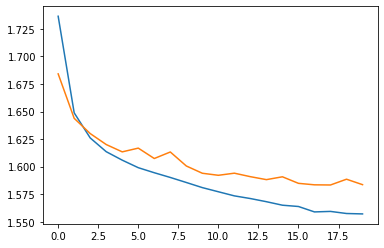

In [ ]:
training(20)

In [ ]:
testiter = iter(testloader)
images, labels = testiter.next()

In [ ]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [ ]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

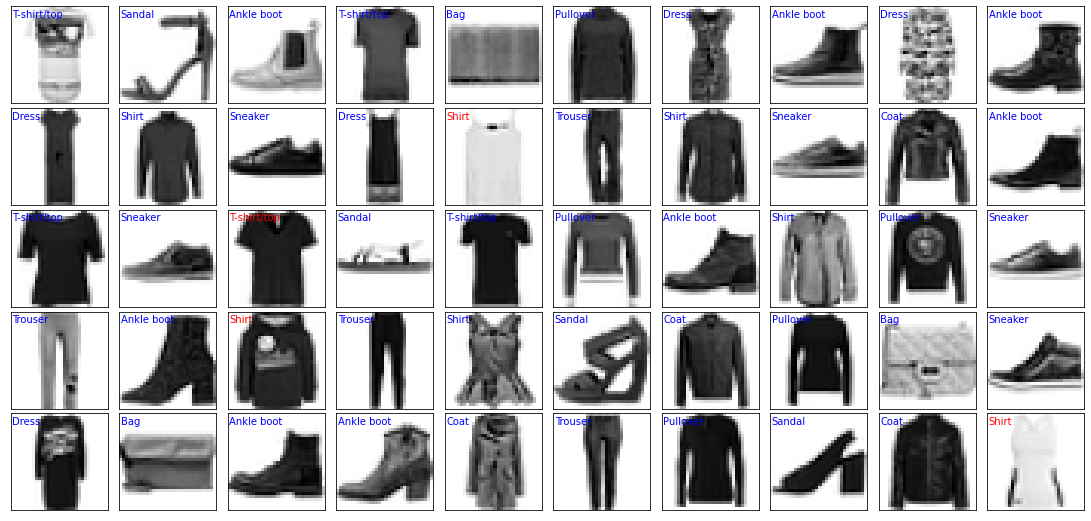

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')